# HW \#4: Experience Replay and Exploration

**Name:**  <font color="red">Alexander Johnston</font>



In this assignment, you are examining experience replay and exploration strategies based on your prior implementations of DQN (HW2) and PPO (HW3)--or their variants.




# I. Overview

Describe the objective of this assignment. You can briefly state how you accompilsh it.

The objective of the assignment is to experiment with exploration and experience replay. I accomplish experience replay by using DQN with Prioritized Experience Replay. I attempted to use noisy linear to improve PPO, but I failed to achieve that objective.


For an AI usage note here, it assisted me with the following:

Creating Matplot charts (Not idea generation just implementation.
Implementing the Noisy Linear, my first implemntation was completely broken.
Getting information about noise to the DQN specific chart.

# II. Environment

To save your computation time, we will only play with Lunar Lander this time. 


## Lunar Lander


https://gymnasium.farama.org/environments/box2d/lunar_lander/

![lunar lander](https://gymnasium.farama.org/_images/lunar_lander.gif)




#### STEPS for Lunar Lander Experiments

1. [II Problems] First, import gymnasium (if you haven't installed it, make sure install gymnasium first.
1. [II Problems] Initialize, learn and test how the environment works.
1. [II Problems] Explain the environment code. 
3. [III Methods] Build your DQN and PPO (or their variants if you did EC assignments).
<hr/>
Well, up to here, you can reuse HW3. :) 
<hr/>

4. [III Methods] Explain your choice of an experience replay method (A) <font color='red'>AND</font> an exploration method (B).  
4. [III Methods] Implement and explain the codes for experiments (A) and (B). 

5. [IV Results]  Present (with proper visualization) the results for both with/without (A) or (B).
5. [IV Results]  Discuss the impact of (A) and (B). 


## Gymnasium explanation

I will explain the environment code here.

I initialized the lunar lander with env = gym.make("LunarLander-v3")

obs_dim and act_dim represent the input and output layers

    for ep in range(num_episodes):
        obs, _ = env.reset()
        done = False
        ep_reward = 0
This resets the environment after every episode and sets up a new episode.



# III. Methods

## III.A Experience Replay

For experience replay, I implemented it onto a DQN method.

- Explain your choice of ER (other than vanilla ER)

- For experience replay, I chose DQN with Prioritized Experience Replay as I saw it mentioned on a list of different experience replay types on reddit. I saw a pretty good github explaining how it could be done to pong, and I went on with it.

- Explain your codes.

Important classes: SumTree, Prioritized Replay Buffer (replaces replay buffer).

First of all, in run_all_configs(), when per is true for configuration, it modifies the use_per flag in init.
if use_per:
            self.memory = PrioritizedReplayBuffer(n_actions, mem_size, batch_size)
        else:
            self.memory = ReplayBuffer(n_actions, mem_size, batch_size)

This creates the differentail paths for DQN and DQN per, with them acting exactly the same except for the usage of the prioritized replay buffer. They both use greedy epsilon for exploraiton.

For the original replay buffer, to pick the sample it simply find a random sample using random.sample. 

This is compared with prioritized replay buffer, which samples based on priority.

SumTree is a binary tree where leaves hold priority values while nodes hold the sum of child priorities.

When samples are added, new transitions get max_priority so they get sampled sooner than later.

This loop is the most important part of the sampling process as it takes the divided priority range and samples a random number in it, and uses self.tree.get(s) to retrieve the expereince that matches s. This ensures high priority experiences will be selected more often while ensuring diversity.

for i in range(self.batch_size):
            s = random.uniform(i * segment, (i + 1) * segment)
            idx, p, data = self.tree.get(s)
            priorities.append(p)
            idxs.append(idx)
            experiences.append(data)


from there,
probs = np.array(priorities) / self.tree.total()
        weights = (len(self) * probs) ** (-beta)
        weights /= weights.max()

a probability is given to each selected experience, then importance weights are calculated.

The sampled data is then used in the learn() function where the weights are applied and loss is computed for each sample. It then continues like normal dqn.

My code for PER DQN is heavily influenced by (https://github.com/rlcode/per) which has a simple implementation of the per buffer and sumtree, which I used to write my implementation. Most implementations of PER I found were nearly identical to this so I mostly emulated this repo.

## III.A Exploration

For exploration replay, I attempted to implement it onto my previous PPO implementation.

- Explain your choice of exploration (other than classical exploration such as $\epsilon$-greedy or UCB)

- I chose this as it seemed simple enough to modify onto my previous PPO implementation and it was in representation rather than action space, making it theoretically easier to implement.

-Explain your codes.

-NoisyLinear is initialized when the noisy condition in the dictionary is true.

NoisyLinear is a layer that replaces nn.Linear by asdding trainable noise to weights/biases. Instead of using 1 weight/bias it has mu and sigma versions where mu is base and sigma scales noise.

During a pass random values are taken into weight and bias epsilon. These compute noisy weights and the same for bias.

weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
bias = self.bias_mu + self.bias_sigma * self.bias_epsilon

This changes the layers output a big each time creating randomness in the network. 

NoisyPPO uses the NoisyLinear instead of standard layers and applies two noisy layers with tanh. This agent as a result explores through internal noise instead of entropy.

It didn't end up working out but it was a neat idea when I saw it.


-

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random
import numpy as np
import gymnasium
from collections import deque, namedtuple
from torch.distributions import Categorical

class PPO_Model(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super(PPO_Model, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh()
        )
        self.policy_head = nn.Linear(64, act_dim)
        self.value_head = nn.Linear(64, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy_head(x), self.value_head(x)

    def act(self, obs):
        logits, value = self.forward(obs)
        dist = Categorical(logits=logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist.entropy(), value

    def evaluate(self, obs, actions):
        logits, value = self.forward(obs)
        dist = Categorical(logits=logits)
        logprobs = dist.log_prob(actions)
        entropy = dist.entropy()
        return logprobs, entropy, value.squeeze()


class PPO_Agent:
    def __init__(self, model, entropy_coef=0.01):
        self.model = model
        self.buffer = []
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.entropy_coef = entropy_coef
        self.gamma = 0.98
        self.gae_lambda = 0.98
        self.eps_clip = 0.2
        self.K_epochs = 4

    def store(self, transition):
        self.buffer.append(transition)

    def update(self):
        obs, act, logp_old, ret, adv = zip(*self.buffer)
        obs = torch.stack(obs)
        act = torch.tensor(act)
        logp_old = torch.stack(logp_old).detach()
        ret = torch.tensor(ret, dtype=torch.float32).detach()
        adv = torch.tensor(adv, dtype=torch.float32).detach()

        for _ in range(self.K_epochs):
            logp, entropy, value = self.model.evaluate(obs, act)
            ratio = torch.exp(logp - logp_old)
            surr1 = ratio * adv
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * adv
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = F.mse_loss(value, ret)
            loss = actor_loss + 0.5 * critic_loss - self.entropy_coef * entropy.mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.buffer.clear()

class QNet(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden=64):
        super(QNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(n_states, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_actions)
        )

    def forward(self, x):
        return self.fc(x)

def compute_gae(buffer, gamma=0.99, gae_lambda=0.95):
    _, _, _, rewards, dones, values = zip(*buffer)
    values = list(values) + [torch.tensor(0.0)]
    gae = 0
    returns = []
    advantages = []

    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * gae_lambda * (1 - dones[t]) * gae
        advantages.insert(0, gae)
        returns.insert(0, gae + values[t])

    return returns, advantages
def decay_epsilon(epsilon, min_eps=0.05, decay=0.995):
    return max(min_eps, epsilon * decay)

class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1
        if left >= len(self.tree):
            return idx
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, p)
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]
        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]

class DQN:
    def __init__(self, n_states, n_actions, batch_size=64, lr=1e-4, gamma=0.99,
                 mem_size=int(1e5), learn_step=5, tau=1e-3, use_per=False):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau
        self.use_per = use_per

        self.net_eval = QNet(n_states, n_actions)
        self.net_target = QNet(n_states, n_actions)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none' if use_per else 'mean')

        if use_per:
            self.memory = PrioritizedReplayBuffer(n_actions, mem_size, batch_size)
        else:
            self.memory = ReplayBuffer(n_actions, mem_size, batch_size)

        self.counter = 0

    def learn(self, experiences):
        if self.use_per:
            states, actions, rewards, next_states, dones, weights, idxs = experiences
        else:
            states, actions, rewards, next_states, dones = experiences
            weights = torch.ones_like(rewards)

        Q_targets_next = self.net_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        Q_expected = self.net_eval(states).gather(1, actions)

        loss = self.criterion(Q_expected, Q_targets)
        if self.use_per:
            weighted_loss = (loss * weights).mean()
        else:
            weighted_loss = loss.mean()

        self.optimizer.zero_grad()
        weighted_loss.backward()
        self.optimizer.step()

        if self.use_per:
            td_errors = Q_targets - Q_expected
            self.memory.update_priorities(idxs, td_errors)

        self.soft_update()

        return weighted_loss.item()

    def act(self, state, eps=0.1):
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0)
            self.net_eval.eval()
            with torch.no_grad():
                action_values = self.net_eval(state)
            self.net_eval.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.n_actions))

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.counter = (self.counter + 1) % self.learn_step
        if self.counter == 0 and len(self.memory) > self.batch_size:
            experiences = self.memory.sample() if not self.use_per else self.memory.sample(beta=0.4)
            return self.learn(experiences)
        return None

        
    def soft_update(self):
        for target_param, eval_param in zip(self.net_target.parameters(), self.net_eval.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)


class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)


class PrioritizedReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, alpha=0.6):
        self.tree = SumTree(buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.alpha = alpha
        self.epsilon = 1e-5

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        max_priority = np.max(self.tree.tree[-self.tree.capacity:]) if self.tree.write > 0 else 1.0
        self.tree.add(max_priority, e)

    def sample(self, beta=0.4):
        experiences = []
        idxs = []
        priorities = []
        segment = self.tree.total() / self.batch_size

        for i in range(self.batch_size):
            s = random.uniform(i * segment, (i + 1) * segment)
            idx, p, data = self.tree.get(s)
            priorities.append(p)
            idxs.append(idx)
            experiences.append(data)

        probs = np.array(priorities) / self.tree.total()
        weights = (len(self) * probs) ** (-beta)
        weights /= weights.max()

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float()
        weights = torch.tensor(weights, dtype=torch.float32).unsqueeze(1)

        return (states, actions, rewards, next_states, dones, weights, idxs)

    def update_priorities(self, idxs, td_errors):
        for idx, td_error in zip(idxs, td_errors.detach().numpy()):
            p = (np.abs(td_error) + self.epsilon) ** self.alpha
            self.tree.update(idx, p)

    def __len__(self):
        return self.tree.write if self.tree.write < self.tree.capacity else self.tree.capacity

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer("bias_epsilon", torch.empty(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        mu_range = 1 / self.in_features ** 0.5
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / self.in_features ** 0.5)
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / self.out_features ** 0.5)

    def forward(self, x):
        self.weight_epsilon.normal_()
        self.bias_epsilon.normal_()
        weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
        bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        return F.linear(x, weight, bias)

class NoisyPPO_Model(PPO_Model):
    def __init__(self, obs_dim, act_dim):
        super(PPO_Model, self).__init__()
        self.shared = nn.Sequential(
            NoisyLinear(obs_dim, 64),
            nn.Tanh(),
            NoisyLinear(64, 64),
            nn.Tanh()
        )
        self.policy_head = NoisyLinear(64, act_dim)
        self.value_head = NoisyLinear(64, 1)

# --- Training Loop ---
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd

def train_with_plot(env, agent, agent_type="PPO", num_episodes=2500):
    import matplotlib.pyplot as plt
    from IPython.display import display, clear_output
    import pandas as pd
    from collections import Counter

    rewards = []
    actions_taken = []
    loss_values = []
    epsilon = 1.0

    # Live plot so my adhd brain can comprehend if thing working or no work
    fig, ax = plt.subplots()
    line, = ax.plot([], [], label=agent_type)
    ax.set_xlim(0, num_episodes)
    ax.set_ylim(-300, 300)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.legend()
    display(fig)

    for ep in range(num_episodes):
        obs, _ = env.reset()
        done = False
        ep_reward = 0

        while not done:
            if agent_type == "DQN":
                action = agent.act(obs, epsilon)
                next_obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                loss = agent.step(obs, action, reward, next_obs, done)
                if loss is not None:
                    loss_values.append(loss)
                actions_taken.append(action)
                epsilon = decay_epsilon(epsilon)
            else:
                obs_tensor = torch.tensor(obs, dtype=torch.float32)
                action, logp, _, value = agent.model.act(obs_tensor)
                next_obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                agent.store((obs_tensor, action, logp, reward, done, value))
                actions_taken.append(action)

            obs = next_obs
            ep_reward += reward

        if agent_type == "PPO":
            returns, advs = compute_gae(agent.buffer, gamma=agent.gamma, gae_lambda=agent.gae_lambda)
            transitions = [
                (t[0], t[1], t[2], torch.tensor(ret), adv)
                for t, ret, adv in zip(agent.buffer, returns, advs)
            ]
            agent.buffer = transitions
            agent.update()

        rewards.append(ep_reward)

        line.set_xdata(range(len(rewards)))
        line.set_ydata(rewards)
        ax.relim()
        ax.autoscale_view()
        clear_output(wait=True)
        display(fig)

        print(f"Episode {ep+1}/{num_episodes} | Reward: {ep_reward:.2f} | Avg (last 50): {np.mean(rewards[-50:]):.2f}")

    return rewards, actions_taken, loss_values


def run_all_configs():
    env = gymnasium.make("LunarLander-v3")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    training_configs = [
        {"agent_type": "PPO", "entropy_coef": 0.01, "noisy": False},
        {"agent_type": "PPO", "entropy_coef": 0.01, "noisy": True},
        {"agent_type": "DQN", "per": False},
        {"agent_type": "DQN", "per": True},
    ]

    results = {}
    actions_per_config = {}
    losses_per_config = {}

    for i, config in enumerate(training_configs):
        print(f"--- Running Training {i+1}: {config} ---")

        if config["agent_type"] == "DQN":
            agent = DQN(obs_dim, act_dim, use_per=config.get("per", False))
        else:
            if config.get("noisy"):
                model = NoisyPPO_Model(obs_dim, act_dim)
            else:
                model = PPO_Model(obs_dim, act_dim)
            agent = PPO_Agent(model, entropy_coef=config["entropy_coef"])

        rewards, actions_taken, loss_values = train_with_plot(env, agent, agent_type=config["agent_type"], num_episodes=2500)

        label = f"{config['agent_type']}"

        if config.get("per"):
            label += " with PER"
        elif config.get("noisy"):
            label += " with NoisyNet"
        
        
        results[label] = rewards
        actions_per_config[label] = actions_taken
        losses_per_config[label] = loss_values
        
        print(f"Average Reward: {np.mean(rewards[-10:]):.2f}")

    clear_output(wait=True)

    import matplotlib.pyplot as plt
    import pandas as pd
    from collections import Counter

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Smooth Reward Curves
    for label, r in results.items():
        smoothed = pd.Series(r).rolling(window=50).mean()
        axs[0, 0].plot(smoothed, label=label)
    axs[0, 0].set_title("Smoothed Reward Curves")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Reward")
    axs[0, 0].legend()

    # Raw Reward Curves
    for label, r in results.items():
        axs[0, 1].plot(r, label=label)
    axs[0, 1].set_title("Raw Reward Curves")
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Reward")
    axs[0, 1].legend()

    # Action Distribution
    action_space = [0, 1, 2, 3]  # LunarLander discrete actions cause it was bugging out really badly
    bar_width = 0.2
    bar_offset = 0
    
    for i, (label, actions) in enumerate(actions_per_config.items()):
        counts = Counter(actions)
        freqs = [counts.get(a, 0) for a in action_space]
        x_positions = [a + bar_offset for a in action_space]
        axs[1, 0].bar(x_positions, freqs, width=bar_width, label=label)
        bar_offset += bar_width 
    
    axs[1, 0].set_xticks([a + bar_width for a in action_space])
    axs[1, 0].set_xticklabels([str(a) for a in action_space])
    axs[1, 0].set_title("Action Distributions")
    axs[1, 0].set_xlabel("Action")
    axs[1, 0].set_ylabel("Count")
    axs[1, 0].legend()

    # Loss Over Time (DQN only)
    for label, losses in losses_per_config.items():
        if "DQN" in label and losses:
            axs[1, 1].plot(losses, label=label)
    axs[1, 1].set_title("Loss Over Time (DQN only)")
    axs[1, 1].set_xlabel("Training Step")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    return results



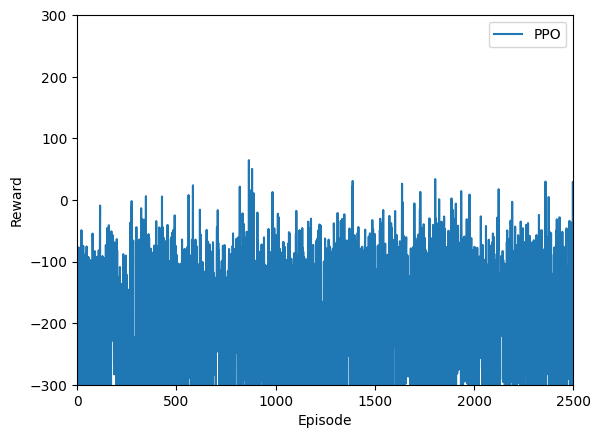

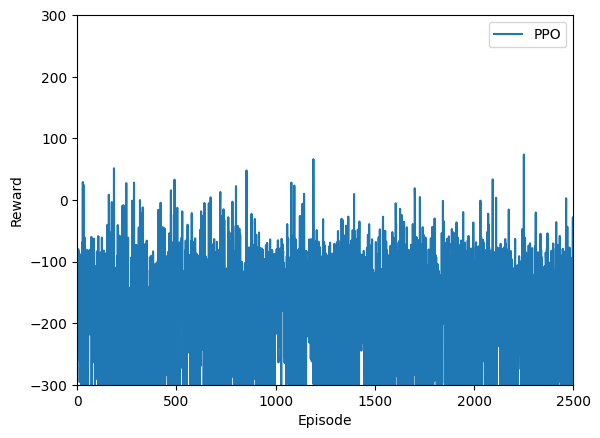

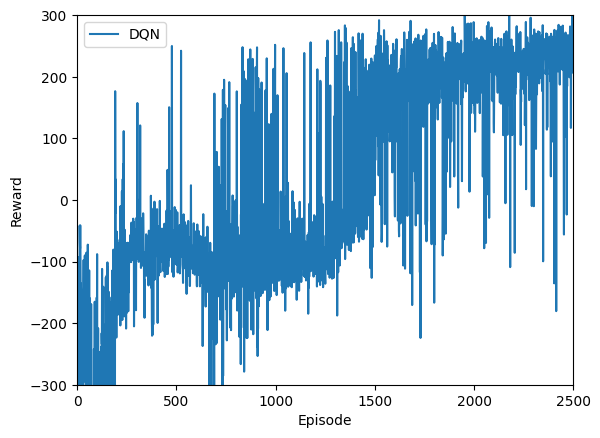

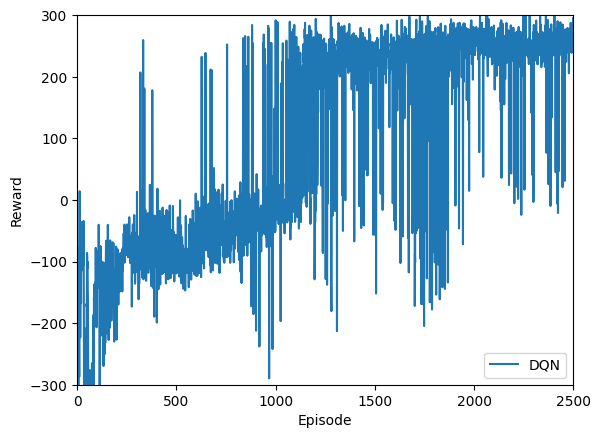

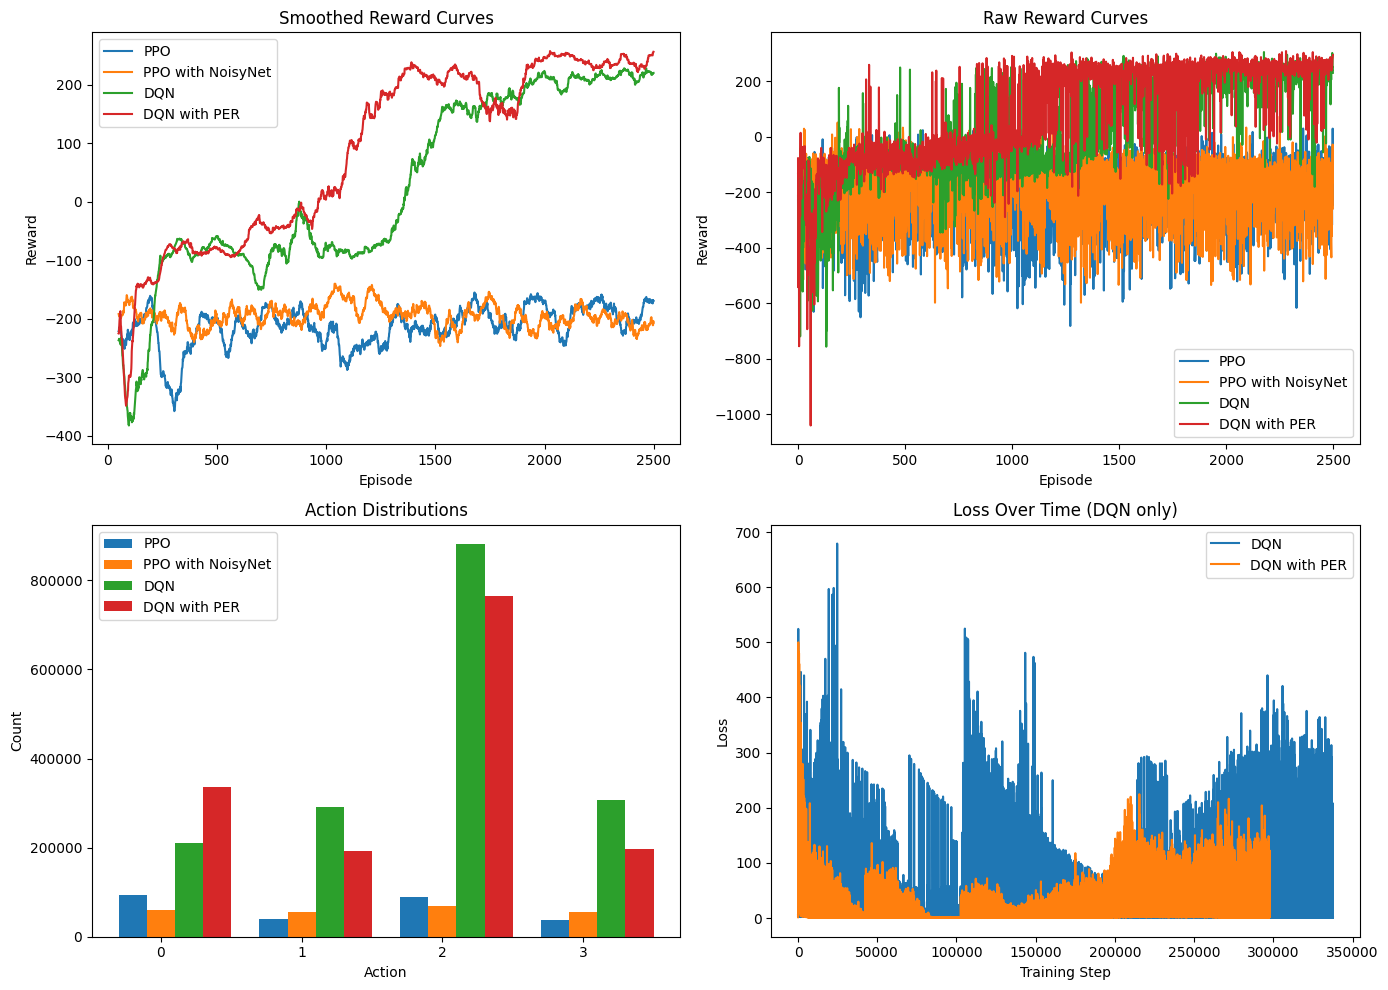

In [27]:
h = run_all_configs()

# IV - Results



- Show the experimental outputs to show the impact of experience replay


  For the Outputs, they are shown above on 2 different graphs, 1 is the raw while the other is averaged over the last 50 episodes to make it clearer. As shown, Only the DQN's are succesful, as I wasn't able to get my previous PPO algorithm to run. I did however achieve a succesful DQN run which was nice. The DQN using PER was significantly more succesful than the standard DQN. As for the PPO methods, there was no tangible difference between the two as they both failed.


- Visualize the results and explain outputs
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.
    - Hint: example visualization can be the reward/return curve, win/lose plot, score plot, etc.
    -       Feel free to try new plots if you want.
    
- DISCUSS the impact of ER and Exploration that you chose.

For exploration, Since the PPO (Normal and using NoisyLinear) methods were neither succesful, I won't talk about them in length, but I saw some resources showing how the Noisy PPO was successful, so I am still unsure what I was doing wrong for it. Typically NoisyLinear would lead to better exploration using learned noise in weights but it really didn't lead to anything positive.

For the DQN and DQN with PER, PER focuses on samples that have high TD error, meaning that when it makes a big jump, it focuses more heavily on the surprising result, which is noticable when looking at the raw training performance graph. You can see multiple times it makes a huge jump and retains the knowledge very effectively, leading to much faster converagance and much more efficient model. As a note, in some trainings it didn't make this huge jump that we see here, but 2/3 times it performs much better than DQN. DQN is still effective and eventually starts to approach these scores, but this shows how effective an experience selection model can be in comparison to a baseline.


As for additional plots, I have provided 3 more above (I also included a png just in case they didn't save for who knows why). They include the following charts:

Actions by agent:
    Good to see how many actions each of the agents took
DQN loss over time:
    This shows the loss at each training step, aka how much it is learning. The DQN PER has many more steps where it learns early as a result of the 0 loss not being included, while the DQN keeps learning after DQN PER has converged.

RAW Reward curve:
    Simply included to see the raw reward at every episode

Last 50 reward curve:
    Shown to give a better average over time for learning, as raw is hard for my weak eyes to look at.

# V. Conclusions

Discuss the challenges or somethat that you learned.
If you have any suggestion about the assignment, you can write about it.

Challenges: I didn't have too many issues with this assignment disregarding the PPO (which I couldn't figure out still). I found a couple of good examples for DQN that I emulated and was able to run successfully.

For this assignment, I learned a lot during the implementation of the DQN algorithm as I had to redo it from scratch, and it showed me how using different Experience replay methods can lead to better success.

I also loved how quickly DQN with PER converged, when I have more time after this semester I'll probably redo the DQN implementation and add an exploration element to it, rather than just having an expereince replay alteration.

# Submission

You are required to submit this notebook file ONLY.


## Grading

For this assignment, the grading rubric is a bit different. Please check it carefully.


points | | description
--|--|:--
5 | Overview| states the objective and the appraoch
10 | Problem |
 |5| Code for setting up the environment
 | 5| Explanation of Lunar Lander problem and the codes to use Lunar Lander from Gymnasium
45 | Methods |
 |5 | codes for DQN and/or PPO
 |10| codes for experience replay (4.1) 
 |10| Explanation of your implementation of experience replay
 |10| codes for exploration (4.2) 
 |10| Explanation of your exploration implementation
30 | Results
 |10| Visualize and compare the impact of experience replay
 |5| Explanation/discussion of the impact of experience replay
 |10| Visualize and compare the impact of exploration
 |5| Explanation/discussion of the impact of exploration
10 | Conclusions
